# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

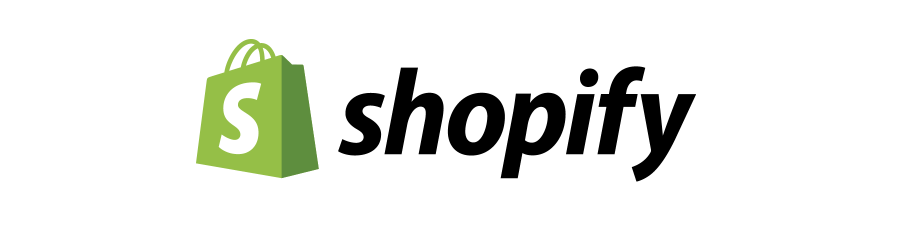

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score

from io import StringIO 
from IPython.display import Image,HTML 
import pydotplus
import graphviz
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def centered(content):
    display(HTML(f"<div style='text-align:center'>{content}</div>"))

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

In [4]:
## We change the pfw_spent column and create a new target column: repeat
customer_cltv['repeat'] = np.where(customer_cltv['pfw_spent'] > 0,1,0)
customer_cltv.drop(columns='pfw_spent',inplace=True)
customer_cltv.head()

,CustomerID,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range,repeat
0,Anonymous13455,1,1,50.0,0,6,0,M,0,0,MW,high,1
1,Anonymous2142,1,1,48.0,0,5,0,L,0,0,NE,high,1
2,Anonymous4843,2,2,96.0,0,10,0,S,1,0,W,high,1
3,Anonymous11225,1,1,16.0,0,1,1,No size,0,0,MW,low,1
4,Anonymous540,1,1,50.0,0,1,0,XS,0,0,W,high,1


<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [5]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [6]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L','M'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,repeat,first_order_feb_june,large_size
0,Anonymous13455,50.0,0,0,0,high,1,1,1
1,Anonymous2142,48.0,0,0,0,high,1,1,1
2,Anonymous4843,96.0,0,1,0,high,1,0,0
3,Anonymous11225,16.0,0,0,0,low,1,0,0
4,Anonymous540,50.0,0,0,0,high,1,0,0


#### We create dummy variables for our categorical variables.

In [7]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,repeat,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,50.0,0,0,0,1,1,1,0,0
1,Anonymous2142,48.0,0,0,0,1,1,1,0,0
2,Anonymous4843,96.0,0,1,0,1,0,0,0,0
3,Anonymous11225,16.0,0,0,0,1,0,0,1,0
4,Anonymous540,50.0,0,0,0,1,0,0,0,0


In [8]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','repeat'])
y = customer_cltv['repeat']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [9]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,1,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


0    7714
1    2876
Name: repeat, dtype: int64


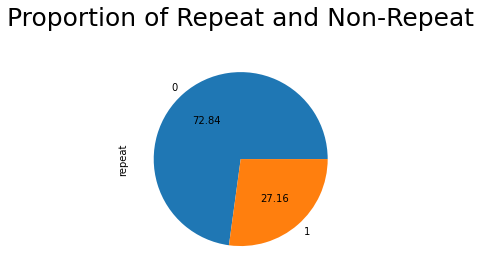

In [10]:
## Look at the balance of the data: Only 27% of our customers are repeat, the non-repeats are over represented.
## This is an example of an imbalanced dataset. 
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')
plt.title('Proportion of Repeat and Non-Repeat', pad =25, fontsize =25)
plt.show()

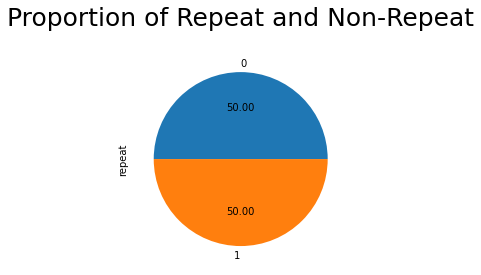

In [11]:
## We proceed with Random Undersampling:
rus = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
#X_res, y_res = rus.fit_resample(X,y)
X, y = rus.fit_resample(X,y)
plt.title('Proportion of Repeat and Non-Repeat', pad =25, fontsize =25)
ax = y.value_counts().plot.pie(autopct='%.2f')

In [12]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4314, 8) (1438, 8) (4314,) (1438,)


# Classification Models
<br> In the previous models, our target feature was **continuous**. We will be treating pwf as a **discrete**.
<br> **We will be using 7 different classification models:**
- 1) Logistic Regression 
- 2) Random Forests
- 3) Gradient Boosting
- 4) SVC 
- 5) K-NN
- 6) Naive Bayes
- 7) Stochastic Gradient Descent

## 1) Logistic Regression 

In [13]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1],
             'penalty':['none','l1','l2','elasticnet']
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy')
lr_cv.fit(X_train,y_train)

## We print the metrics: 
print('Best Estimator:' +str(lr_cv.best_estimator_))
print('Best Params:' +str(lr_cv.best_params_))
print('Best Score:' +str(lr_cv.best_score_))

## With the best parameters, we re-instantiate the model, fit and predict the outcomes. 
best_lreg = LogisticRegression(C = 0.01, l1_ratio= 0, penalty = 'l2')

Best Estimator:LogisticRegression(C=1, l1_ratio=0)
Best Params:{'C': 1, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5628158030420212


## 2 Random Forests:

In [14]:
'''
## Prior to using GridSeachCV, we can see the effect of n_estimators on testing accuracy. 
scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred_rf = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_rf))

# plot the relationship between K and testing accuracy
plt.figure(figsize=(14,7))
plt.plot(range(1, 200), scores, color ='g', linestyle ='--')
plt.xlabel('N Estimator Value in RF Model')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy across multiple n_estimator values', fontsize = 25, pad =20)
plt.show()
## Code inspired from: https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier
'''

"\n## Prior to using GridSeachCV, we can see the effect of n_estimators on testing accuracy. \nscores =[]\nfor k in range(1, 200):\n    rfc = RandomForestClassifier(n_estimators=k)\n    rfc.fit(X_train, y_train)\n    y_pred_rf = rfc.predict(X_test)\n    scores.append(accuracy_score(y_test, y_pred_rf))\n\n# plot the relationship between K and testing accuracy\nplt.figure(figsize=(14,7))\nplt.plot(range(1, 200), scores, color ='g', linestyle ='--')\nplt.xlabel('N Estimator Value in RF Model')\nplt.ylabel('Testing Accuracy')\nplt.title('Testing Accuracy across multiple n_estimator values', fontsize = 25, pad =20)\nplt.show()\n## Code inspired from: https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier\n"

In [15]:
## We use GridSearchCV to find the best hyperparameters of RandomForest. 
'''
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ['gini','entropy'],
    'max_depth' : [2,4,6,8],
    'bootstrap':['False', 'True']
}

rfc_GS = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
rfc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(rfc_GS.best_estimator_))
print('Best Params:' +str(rfc_GS.best_params_))
print('Best Score:' +str(rfc_GS.best_score_))
'''
## The findings for the above is as follows below: 

'''
Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=6, max_features='sqrt',
                       random_state=42)
Best Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score:0.5706973730551979
'''

"\nBest Estimator:RandomForestClassifier(bootstrap='False', max_depth=6, max_features='sqrt',\n                       random_state=42)\nBest Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}\nBest Score:0.5706973730551979\n"

In [16]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 6, 
                                  max_features= 'sqrt', n_estimators= 100, random_state = 42)

In [17]:
## We can see the feature importances in the model below...
rfc_best.fit(X_train,y_train)
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

,importance
fw_total_spent,0.602519
first_order_feb_june,0.116387
large_size,0.071172
first_item_price_range_low,0.057549
accepts_marketing,0.045477
wealthy_zip,0.038944
fw_used_coupon,0.037791
first_item_price_range_medium,0.030161


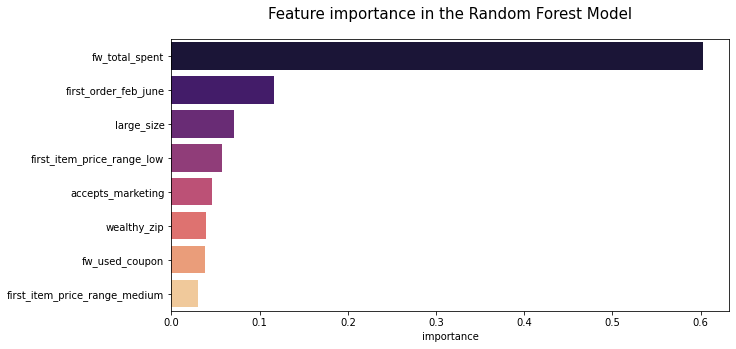

In [18]:
## ... and we can plot them. 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

## 3) Gradient Boosting:

In [19]:
## We use GridSearchCV to find the best hyperparameters for Gradient Boosting
'''
gbc = GradientBoostingClassifier(random_state = 42)
param_grid = { 
    'loss': ['exponential','deviance'],
    'n_estimators': [1,2,5,10,20,100],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth' : [2,6,8,10],
}

gbc_GS = GridSearchCV(gbc, param_grid, cv=5, scoring='accuracy')
gbc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(gbc_GS.best_estimator_))
print('Best Params:' +str(gbc_GS.best_params_))
print('Best Score:' +str(gbc_GS.best_score_))
'''

## The findings for the above is as follows below: 
'''
Best Estimator:GradientBoostingClassifier(criterion='mae', max_depth=10, n_estimators=1,
                           random_state=42)
Best Params:{'criterion': 'mae', 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1}
Best Score:0.560960659007993
'''

"\nBest Estimator:GradientBoostingClassifier(criterion='mae', max_depth=10, n_estimators=1,\n                           random_state=42)\nBest Params:{'criterion': 'mae', 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1}\nBest Score:0.560960659007993\n"

In [20]:
## We  fit the Predictor.
gbc_best = GradientBoostingClassifier(criterion= 'mae', max_depth= 10, 
                                      max_features= 'sqrt', n_estimators= 1, loss ='deviance',
                                      random_state = 42)

## 4) SVC

In [21]:
## We use GridSearch to get the best parameters for SVC
'''
svc = SVC(random_state = 42)
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
             }

svc_GS = GridSearchCV(svc, param_grid, scoring='accuracy')
svc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(svc_GS.best_estimator_))
print('Best Params:' +str(svc_GS.best_params_))
print('Best Score:' +str(svc_GS.best_score_))
'''

## This is the result of GridSearchCV (takes close to 30 min to run): 
'''
Best Estimator:SVC(C=0.1, gamma=1, random_state=42)
Best Params:{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Score:0.5651377996682377
'''
## We re-instantiate SVC with the best parameters.
svc_best = SVC(C=0.1, gamma=1, kernel = 'rbf',random_state = 42, probability = True)

## 5) K-Nearest Neighbors

In [22]:
## We useGridSearch to get the best knn hyperparameters
'''
knn = KNeighborsClassifier()
k_range  = list(range(1,20))

parameters_KNN = {
    'n_neighbors': list(range(1,31)),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
     }

knn_GS = GridSearchCV(knn, parameters_KNN, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
knn_GS.fit(X_train,y_train)

print('Best Estimator:' +str(knn_GS.best_estimator_))
print('Best Params:' +str(knn_GS.best_params_))
print('Best Score:' +str(knn_GS.best_score_))
'''

## Results of GridSearch CV:  
'''
Best Estimator:KNeighborsClassifier(leaf_size=20, n_neighbors=15, weights='distance')
Best Params:{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Best Score:0.5653508206582452
'''
## We re-instantiate with the best parameters. 
knn_best = KNeighborsClassifier(leaf_size= 20, metric= 'minkowski', n_neighbors= 15, p= 2, weights= 'distance')

## 6) Naive Bayes

In [23]:
## We use GridSearch CV to get the best parameters to maximize the accuracy
nb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_GS = GridSearchCV(nb, param_grid = params_NB , cv=10, scoring='accuracy', return_train_score=False, verbose=1)
nb_GS.fit(X_train,y_train)

## We print out the result
print('Best Estimator:' +str(nb_GS.best_estimator_))
print('Best Params:' +str(nb_GS.best_params_))
print('Best Score:' +str(nb_GS.best_score_))
## We refit the model with the best parameters found above. 
nb_best = GaussianNB(var_smoothing=0.12328467394420659)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Estimator:GaussianNB(var_smoothing=0.12328467394420659)
Best Params:{'var_smoothing': 0.12328467394420659}
Best Score:0.557709246369339


## 7) Stochastic Gradient Descent

In [24]:
## We use GridSearchCV to find the best parameters to maximize accuracy. 
sgd = SGDClassifier(random_state = 42)
param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}
sgd_GS = GridSearchCV(sgd, param_grid=param_grid, n_jobs=-1, scoring='accuracy')
sgd_GS.fit(X_train,y_train)

## We print out thr results. 
print('Best Estimator:' +str(sgd_GS.best_estimator_))
print('Best Params:' +str(sgd_GS.best_params_))
print('Best Score:' +str(sgd_GS.best_score_))

## We fit the SGDClassifier with the best parameters found above. 
sgd_best = SGDClassifier(alpha= 0.01, l1_ratio= 1, loss = 'log', penalty = 'elasticnet', random_state = 42)

Best Estimator:SGDClassifier(alpha=0.01, l1_ratio=1, loss='log', penalty='elasticnet',
              random_state=42)
Best Params:{'alpha': 0.01, 'l1_ratio': 1, 'loss': 'log', 'penalty': 'elasticnet'}
Best Score:0.5658295537339395


## 8) ADABOOST 

In [25]:
## We use GridSearchCV to find the best parameters to maximize accuracy. 
'''
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),random_state=42)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

ada_GS = GridSearchCV(ada, parameters,verbose=3,scoring='accuracy',n_jobs=-1)
ada_GS.fit(X_train,y_train)

print('Best Estimator:' +str(ada_GS.best_estimator_))
print('Best Params:' +str(ada_GS.best_params_))
print('Best Score:' +str(ada_GS.best_score_))
'''
## This is what we get: 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5,
                                                         random_state=42),
                   learning_rate=0.01, random_state=42)
Best Params:{'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 
'n_estimators': 50}
Best Score:0.5621188698572132
'''
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=5,random_state=42),
                                                           learning_rate=0.01, n_estimators=50, random_state=42)

## 9 ) XGBOOST 

In [26]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=1, seed = 42)
clf_xgb.fit(X_train,y_train, verbose = True, early_stopping_rounds =10, eval_metric ='logloss', 
            eval_set = [(X_test,y_test)])

[0]	validation_0-logloss:0.68381
[1]	validation_0-logloss:0.68030
[2]	validation_0-logloss:0.67854
[3]	validation_0-logloss:0.67681
[4]	validation_0-logloss:0.67577
[5]	validation_0-logloss:0.67556
[6]	validation_0-logloss:0.67547
[7]	validation_0-logloss:0.67608
[8]	validation_0-logloss:0.67695
[9]	validation_0-logloss:0.67699
[10]	validation_0-logloss:0.67792
[11]	validation_0-logloss:0.67857
[12]	validation_0-logloss:0.67875
[13]	validation_0-logloss:0.67886
[14]	validation_0-logloss:0.67889
[15]	validation_0-logloss:0.67886


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

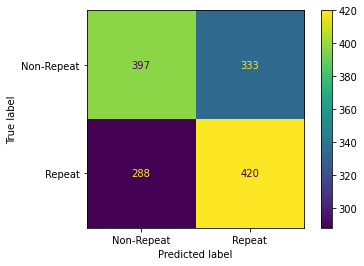

In [27]:
plot_confusion_matrix(clf_xgb,X_test,y_test, values_format ='d',display_labels=['Non-Repeat','Repeat'])
plt.show()

In [28]:
## NOTE: When data are imbalanced, the XGBoost manual says...
## If you care only about the overall performance metric (AUC) of your prediction
##     * Balance the positive and negative weights via scale_pos_weight
##     * Use AUC for evaluation
## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
## in order to optimize parameters in a short period of time.

# ROUND 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
}
# Output: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 10.0}

## ROUND 2
#'''
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0],
    'reg_lambda': [10.0, 20, 100],
}
#'''
## Output: 

## NOTE: To speed up cross validiation, and to further prevent overfitting.
## We are only using a random subset of the data (90%) and are only
## using a random subset of the features (columns) (50%) per tree.
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                eval_metric="logloss", 
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                use_label_encoder=False),
    param_grid=param_grid,
    scoring='accuracy', 
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)
print(optimal_params.best_estimator_)
print(optimal_params.best_score_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=100, scale_pos_weight=1,
              seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)
0.5609628098173693


In [29]:
xgb_best = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="auc", 
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=3,
                        reg_lambda=20,
                        scale_pos_weight=1,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
xgb_best.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.59106
[1]	validation_0-auc:0.60060
[2]	validation_0-auc:0.60766
[3]	validation_0-auc:0.60581
[4]	validation_0-auc:0.60900
[5]	validation_0-auc:0.60877
[6]	validation_0-auc:0.60978
[7]	validation_0-auc:0.60765
[8]	validation_0-auc:0.60757
[9]	validation_0-auc:0.60863
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.60804
[12]	validation_0-auc:0.60876
[13]	validation_0-auc:0.60792
[14]	validation_0-auc:0.60972
[15]	validation_0-auc:0.60840


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0.25,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=20, scale_pos_weight=1,
              seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

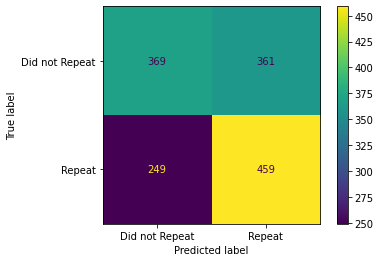

In [30]:
plot_confusion_matrix(xgb_best, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not Repeat", "Repeat"])
plt.show()

## Plotting ROC and AUC

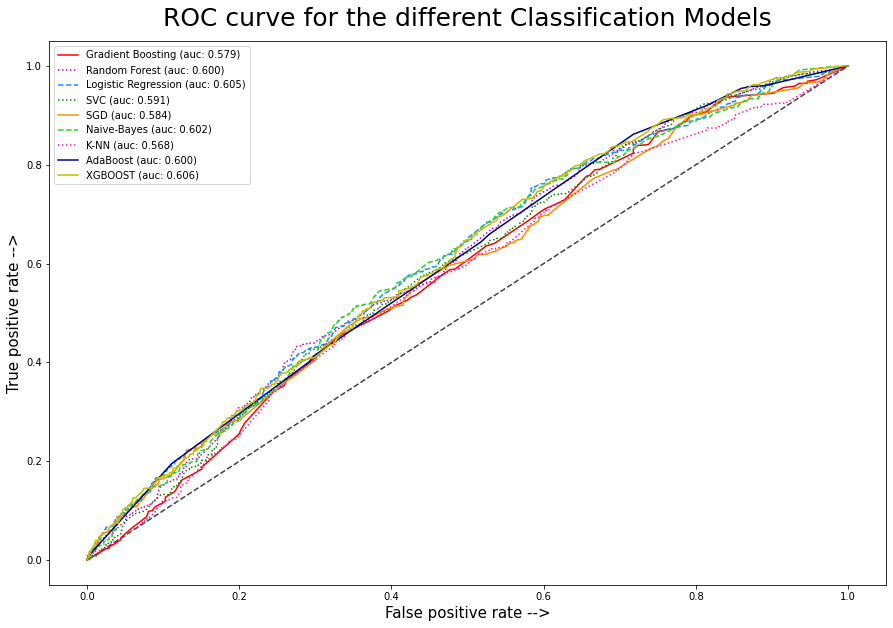

In [31]:
## We plot the ROC and AUC 
names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN",'AdaBoost',"XGBOOST"]
clfs = [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best, ada_best,xgb_best]

## Parameters for the plotting 
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))
counter = 0
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    #print("Roc AUC:"+name, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')) ## Can uncomment
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name+ ' (auc: %0.3f)' %roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'),
             linestyle=linestyles[counter], c=colors[counter])
    counter += 1
## Plot a straight line that goes throug
lims = [np.min([0.0, 0.0]),  np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')

plt.xlabel('False positive rate -->', fontsize = 15)
plt.ylabel('True positive rate -->', fontsize = 15)
plt.title('ROC curve for the different Classification Models', pad =15, fontsize = 25)
plt.legend(loc='best')
plt.savefig('roc_auc_classification_resampled_accuracy.png')
plt.show()  

## Evaluating our Models and Plotting the Confusion Matrices: 

Gradient Boosting Model
ROC_AUC_SCORE: 0.579
Accuracy: 0.555
Precision: 0.545
Recall: 0.588
F1-Score: 0.565


Random Forest Model
ROC_AUC_SCORE: 0.6
Accuracy: 0.561
Precision: 0.549
Recall: 0.597
F1-Score: 0.572


Logistic Regression Model
ROC_AUC_SCORE: 0.605
Accuracy: 0.576
Precision: 0.569
Recall: 0.575
F1-Score: 0.572


SVC Model
ROC_AUC_SCORE: 0.591
Accuracy: 0.554
Precision: 0.538
Recall: 0.662
F1-Score: 0.594


SGD Model
ROC_AUC_SCORE: 0.584
Accuracy: 0.545
Precision: 0.533
Recall: 0.621
F1-Score: 0.574


Naive-Bayes Model
ROC_AUC_SCORE: 0.602
Accuracy: 0.566
Precision: 0.58
Recall: 0.432
F1-Score: 0.495


K-NN Model
ROC_AUC_SCORE: 0.568
Accuracy: 0.557
Precision: 0.557
Recall: 0.493
F1-Score: 0.523


AdaBoost Model
ROC_AUC_SCORE: 0.6
Accuracy: 0.564
Precision: 0.547
Recall: 0.66
F1-Score: 0.598


XGBOOST Model
ROC_AUC_SCORE: 0.606
Accuracy: 0.561
Precision: 0.551
Recall: 0.592
F1-Score: 0.57




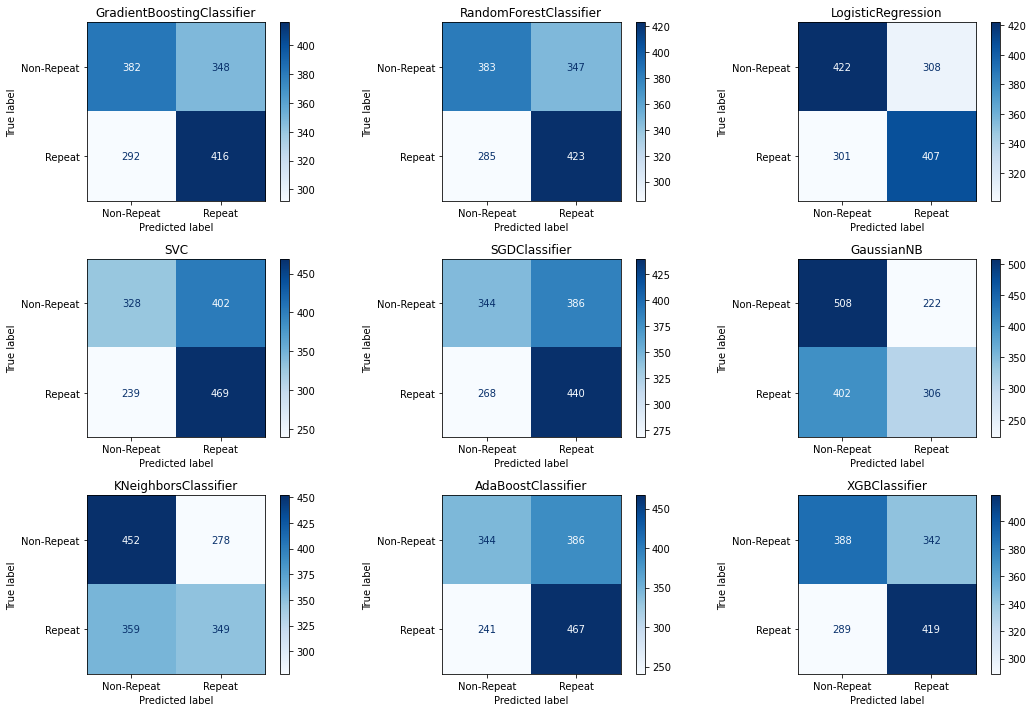

In [32]:
names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN","AdaBoost","XGBOOST"]
models = [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best,ada_best,xgb_best]

counter = 0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('{} Model'.format(names[counter]))
    print('ROC_AUC_SCORE: ' + str(round(roc_auc,3)))
    print('Accuracy: ' + str(round(accuracy_score(y_test,y_pred),3)))
    print('Precision: '+ str(round(precision_score(y_test,y_pred),3)))
    print('Recall: ' + str(round(recall_score(y_test,y_pred),3)))
    print('F1-Score: ' + str(round(f1_score(y_test,y_pred),3)))
    print("\n")
    counter +=1
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['Non-Repeat','Repeat'])
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()

## Code Partially Inspired from:
#https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix

## Visualizing the Precision / Recall Tradeoff

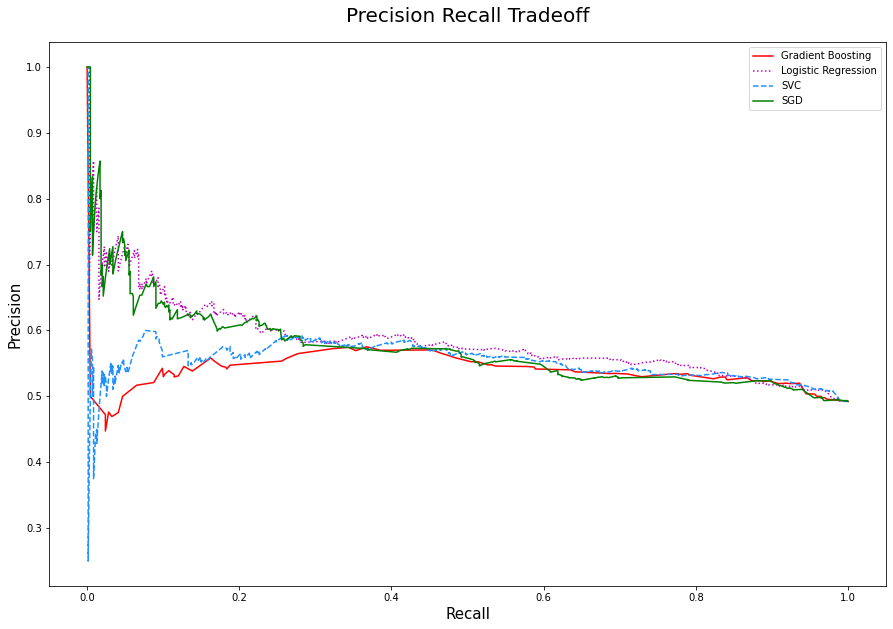

In [33]:
## Plotting the Precision / Recall Tradeoff 

names = ["Gradient Boosting","Logistic Regression","SVC","SGD"]
models = [gbc_best,best_lreg,svc_best,sgd_best]
colors = ['r','m','dodgerblue','g', 'deeppink']
linestyles =['-',':','--','-']

plt.figure(figsize=(15,10))
counter = 0
for name, model in zip(names,models):
    y_decision_function = model.decision_function(X_test)
    precision,recall,threshold = precision_recall_curve(y_test,y_decision_function)
    plt.plot(recall,precision,color=colors[counter], 
             linestyle=linestyles[counter], 
             label = name)
    counter +=1
    
plt.title('Precision Recall Tradeoff', pad=20, fontsize = 20)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.legend()
plt.show()

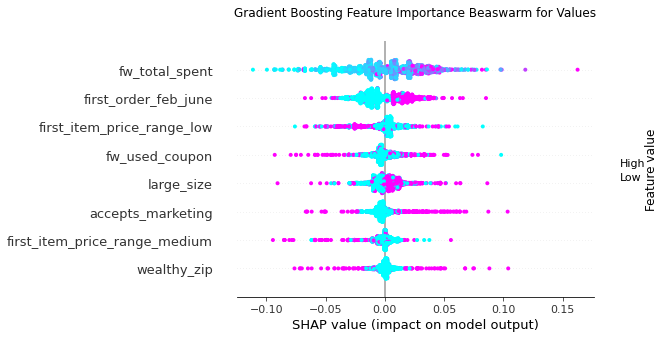

In [34]:
plt.title('Gradient Boosting Feature Importance Beaswarm for Values',pad = 25)
explainer = shap.Explainer(gbc_best)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, color = plt.get_cmap("cool"))